<h3>3.2 实现神经网络实例</h3>

3.2.1 背景说明

In [5]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from tensorboardX import SummaryWriter

In [6]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [7]:
# 定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
# 下载数据，并对数据进行预处理
# 已有数据，download=False
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# 得到一个生成器
# DataLoader是一个可迭代对象，可以使用迭代器一样使用
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

3.2.3 可视化源数据

torch.Size([128, 1, 28, 28])


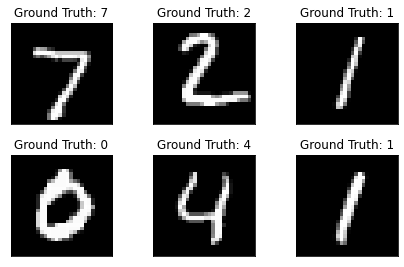

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

3.2.4 构建模型

In [9]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [10]:
lr = 0.01
momentum = 0.9

In [11]:
# 检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs")
#     # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#     # model = nn.DataParallel(model)
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

3.2.5 训练模型

In [12]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
writer = SummaryWriter(log_dir='logs',comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 保存loss的数据与epoch数值
        writer.add_scalar('Train', train_loss/len(train_loader), epoch)
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader),
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

0.009000000000000001
epoch: 0, Train Loss: 0.2267, Train Acc: 0.9351, Test Loss: 0.0899, Test Acc: 0.9727
epoch: 1, Train Loss: 0.0874, Train Acc: 0.9737, Test Loss: 0.0757, Test Acc: 0.9773
epoch: 2, Train Loss: 0.0597, Train Acc: 0.9817, Test Loss: 0.0641, Test Acc: 0.9798
epoch: 3, Train Loss: 0.0463, Train Acc: 0.9852, Test Loss: 0.0611, Test Acc: 0.9804
epoch: 4, Train Loss: 0.0341, Train Acc: 0.9895, Test Loss: 0.0644, Test Acc: 0.9792
0.008100000000000001
epoch: 5, Train Loss: 0.0248, Train Acc: 0.9929, Test Loss: 0.0556, Test Acc: 0.9827
epoch: 6, Train Loss: 0.0197, Train Acc: 0.9944, Test Loss: 0.0570, Test Acc: 0.9821
epoch: 7, Train Loss: 0.0169, Train Acc: 0.9951, Test Loss: 0.0562, Test Acc: 0.9825
epoch: 8, Train Loss: 0.0131, Train Acc: 0.9964, Test Loss: 0.0589, Test Acc: 0.9816
epoch: 9, Train Loss: 0.0109, Train Acc: 0.9972, Test Loss: 0.0562, Test Acc: 0.9819
0.007290000000000001
epoch: 10, Train Loss: 0.0092, Train Acc: 0.9976, Test Loss: 0.0550, Test Acc: 0.9841
e

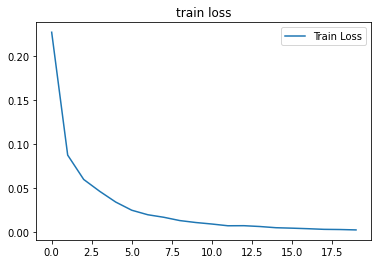

In [13]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
# plt.plot(np.arange(len(eval_losses)), eval_losses)
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')
